https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

Sequence to sequence learning is about training models to convert sequences from one domain to sequences in another domain. This can be used for machine translation or for free-form question answering or in general, it is applicable any time you need to generate text

There are multiple ways to handle this task, either using RNNs or using 1D convnets.

# Trivial case - Input and output sequences have same length

When both input sequences and output sequences have the same length, you can implement such models simply with a keras LSTM or GRU layer. (or a stack)

Teaching a RNN to learn to add numbers, encoded as character strings

Input "535+51"
Output "596"

In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np

Using TensorFlow backend.


In [2]:
class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.

        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.

        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

In [3]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
INVERT = True

In [4]:
# Maximum length of input (e.g., '345+678')
MAXLEN = DIGITS + 1 + DIGITS

In [5]:
# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

In [6]:
print('Generating data...')
questions = []
expected = []
seen = set()
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if INVERT:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 50000


In [7]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [8]:
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

In [9]:
# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

In [10]:
print('Training Data:')
print(x_train.shape)
print(y_train.shape)

Training Data:
(45000, 7, 12)
(45000, 4, 12)


In [11]:
print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Validation Data:
(5000, 7, 12)
(5000, 4, 12)


In [12]:
from keras.layers import LSTM

In [13]:
model = Sequential()

# Encode the input sequence using LSTM
model.add(LSTM(128, input_shape = (MAXLEN, len(chars))))

# As the decoder RNN's input,
# repeatedly provide with the last hidden state of RNN for each time step
# DIGITS+1 as that's the maximum length of the output, e.g. max output is 999+999 = 1998
model.add(layers.RepeatVector(DIGITS + 1))

# By setting return_sequences to True, return not only the last output but
# all the outputs so far in the form of (num_samples, timesteps, output_dim).
model.add(LSTM(128, return_sequences = True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


In [17]:
from keras.utils import plot_model
plot_model(model, to_file='keras-seq-to-seq-1.png', show_shapes=True, show_layer_names=True)  
from IPython.display import FileLink
FileLink('keras-seq-to-seq-1.png')

/home/sainath/code/nlp-tutorials-notes/keras-seq-to-seq-1.png

In [18]:
model.fit(x_train, y_train, batch_size=128, epochs=25, verbose=2, validation_data=(x_val, y_val))

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
 - 13s - loss: 1.8919 - acc: 0.3208 - val_loss: 1.7983 - val_acc: 0.3449
Epoch 2/25
 - 11s - loss: 1.7564 - acc: 0.3529 - val_loss: 1.7223 - val_acc: 0.3641
Epoch 3/25
 - 11s - loss: 1.6399 - acc: 0.3879 - val_loss: 1.5623 - val_acc: 0.4140
Epoch 4/25
 - 11s - loss: 1.4697 - acc: 0.4493 - val_loss: 1.3708 - val_acc: 0.4824
Epoch 5/25
 - 11s - loss: 1.3024 - acc: 0.5149 - val_loss: 1.2388 - val_acc: 0.5427
Epoch 6/25
 - 11s - loss: 1.1791 - acc: 0.5647 - val_loss: 1.1160 - val_acc: 0.5921
Epoch 7/25
 - 11s - loss: 1.0600 - acc: 0.6125 - val_loss: 1.0079 - val_acc: 0.6348
Epoch 8/25
 - 11s - loss: 0.9552 - acc: 0.6565 - val_loss: 0.9138 - val_acc: 0.6624
Epoch 9/25
 - 11s - loss: 0.8605 - acc: 0.6935 - val_loss: 0.8214 - val_acc: 0.7107
Epoch 10/25
 - 11s - loss: 0.7647 - acc: 0.7299 - val_loss: 0.7095 - val_acc: 0.7479
Epoch 11/25
 - 11s - loss: 0.5890 - acc: 0.7935 - val_loss: 0.4862 - val_acc: 0.8368
Epoch 12/25
 - 11s - loss

# General case: different input and output sequence lengths

Here's how it works:
- A RNN Layer (or stack thereof) acts as 'encoder': it processes the input sequence and returns its own internal state. Note that we discard the outputs of the encoder RNN, only recovering the state. This state will serve as the 'context' or 'conditioning' of the decoder in the next step.
- Another RNN layer (or stack thereof) acts as 'decoder': it is trained to predict the next characters of the target sequence, given previous characters of the target sequence. Specifically, it is trained to turn the target sequences into the same sequences but offset by onetimestep in the future, a training process called 'teacher forcing' in this context. Importantly, the encoder uses as initial state the state vectors from the encoder, which is how the decoder obtans information about what it is supposed to generate. Effectively, the decoder learns to generate targets[t+1...] given targets[...t], conditioned on the input sequence.

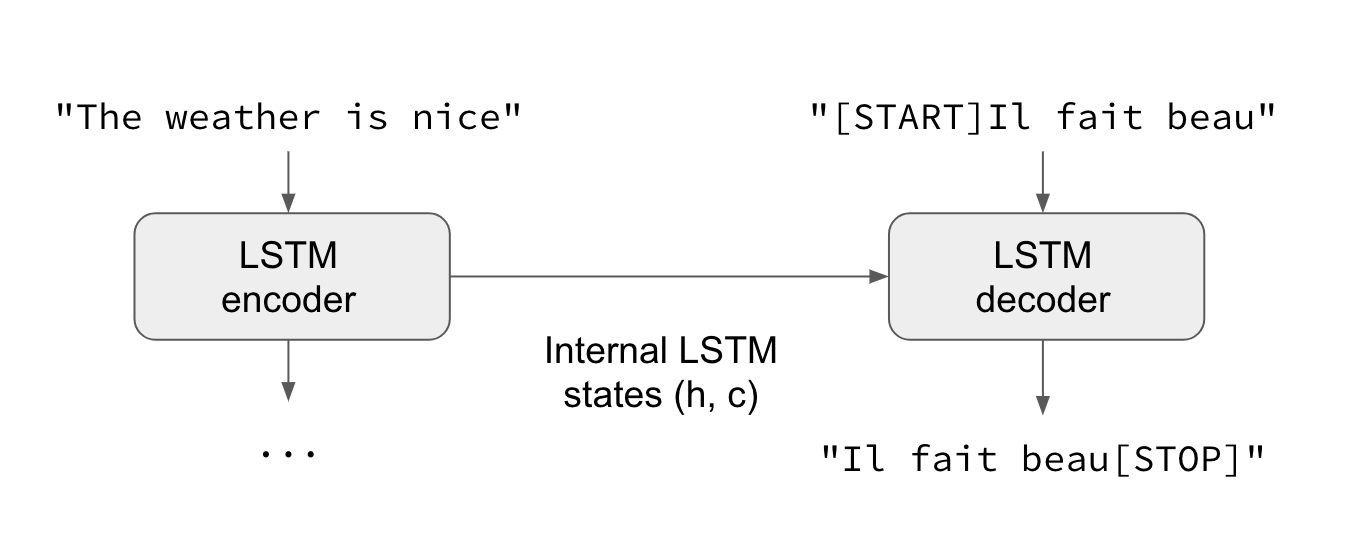

In inference mode, i.e. when we want to decode unknown input sequences, we go through a slightly different process:
1. Encode the input sequence into state vectors
2. Start with a target sequence of size 1 (just the start of the sequence character)
3. Feed the state vectors and 1-char target sequence to the decoder to produce predictions for the next character
4. Sample the next character using these predictions (we simply use argmax)
5. Append the sampled character to the target sequence
6. Repeat unitil we generate the end-of-sequence character or we hit the character limit

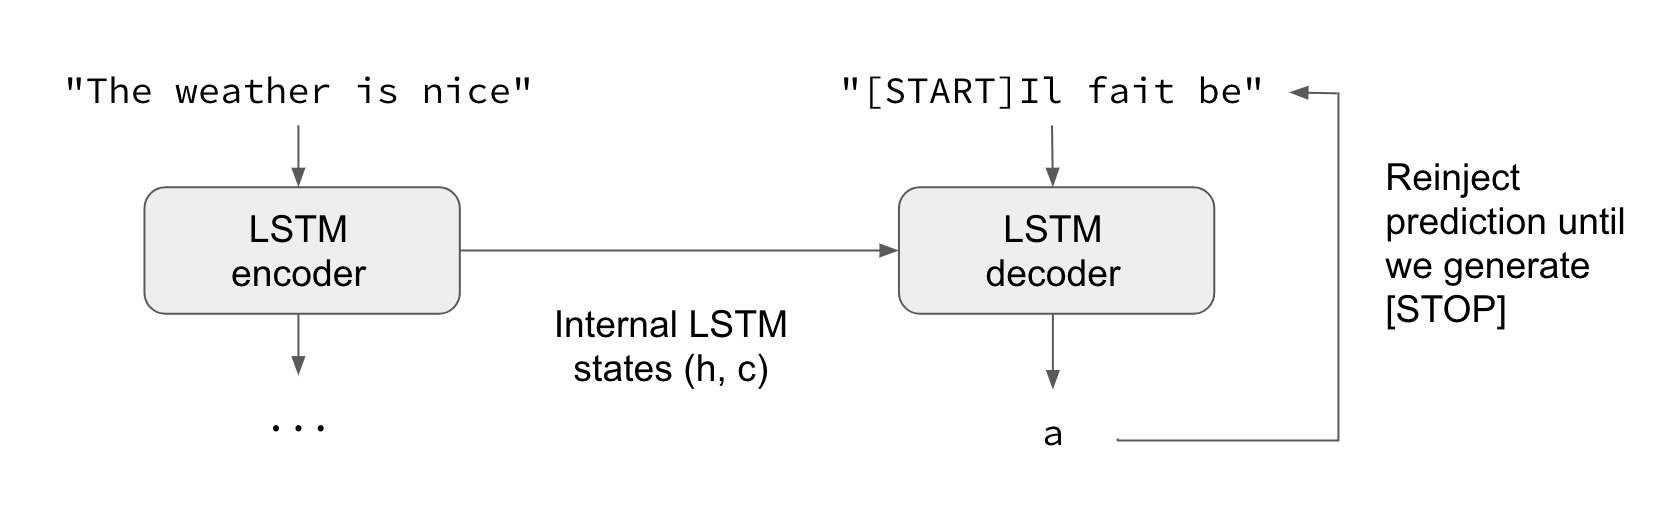

We will implement a basic character level sequence to sequence model. We apply it to translating short english sentences into short french sentences, character by character. Not that it is fairly unusual to do character-level machine translation, as word-level models are more common in this domain.

1. Turn the sentences into 3 np arrays, encoder_input_data, decoder_input_data, decoder_target_data:
    - encoder_input_data is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the english sentences
    - decoder_input_data is a 3D array of shape (num_paris, max_frence_sentence_length, num_french_characters_ containing a one-hot vectorization of the french sentences
    - decoder_target_data is the same as decoder_input_data but offset by one timestep
2. Train a basic LSTM-based Seq2Seq model to predict decoder_target_data given encoder_input_data and decoder_input_data. Our model uses teacher forcing.
3. Decode some sentences to check that the model is working

In [1]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

Using TensorFlow backend.


In [2]:
batch_size = 64      # Batch size for training.
epochs = 100         # Number of epochs to train for.
latent_dim = 256     # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
data_path = './data/fra.txt' # Path to the data txt file on disk

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
lines = open(data_path).read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [4]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [5]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [6]:
input_token_index  = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [7]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [8]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

Because the training process and inference process (decoding sentences) are quite different, we use different models for both, albeit they all leverage the same inner layers.

This is our training model. It leverages three key features of Keras RNNs:
- The return_state contructor argument, configuring a RNN layer to return a list where the first entry is the outputs and the next entries are the internal RNN states. This is used to recover the states of the encoder.
- The inital_state call argument, specifying the initial state(s) of a RNN. This is used to pass the encoder states to the decoder as initial states.
- The return_sequences constructor argument, configuring a RNN to return its full sequence of outputs (instead of just the last output, which the defaults behavior). This is used in the decoder.

In [9]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [10]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [11]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 71)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 93)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 335872      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  358400      input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [13]:
from keras.utils import plot_model
plot_model(model, to_file='keras-seq-to-seq-2.png', show_shapes=True, show_layer_names=True)  
from IPython.display import FileLink
FileLink('keras-seq-to-seq-2.png')

/home/sainath/code/nlp-tutorials-notes/keras-seq-to-seq-2.png

In [14]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          verbose=2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 19s - loss: 0.9302 - val_loss: 0.9850
Epoch 2/100
 - 18s - loss: 0.7367 - val_loss: 0.7869
Epoch 3/100
 - 17s - loss: 0.6253 - val_loss: 0.7140
Epoch 4/100
 - 17s - loss: 0.5694 - val_loss: 0.6652
Epoch 5/100
 - 18s - loss: 0.5290 - val_loss: 0.6307
Epoch 6/100
 - 17s - loss: 0.4964 - val_loss: 0.6036
Epoch 7/100
 - 17s - loss: 0.4696 - val_loss: 0.5835
Epoch 8/100
 - 17s - loss: 0.4465 - val_loss: 0.5658
Epoch 9/100
 - 17s - loss: 0.4267 - val_loss: 0.5488
Epoch 10/100
 - 17s - loss: 0.4095 - val_loss: 0.5401
Epoch 11/100
 - 18s - loss: 0.3937 - val_loss: 0.5312
Epoch 12/100
 - 17s - loss: 0.3793 - val_loss: 0.5204
Epoch 13/100
 - 17s - loss: 0.3653 - val_loss: 0.5117
Epoch 14/100
 - 17s - loss: 0.3524 - val_loss: 0.5078
Epoch 15/100
 - 17s - loss: 0.3400 - val_loss: 0.5003
Epoch 16/100
 - 17s - loss: 0.3284 - val_loss: 0.4960
Epoch 17/100
 - 17s - loss: 0.3175 - val_loss: 0.4954
Epoch 18/100
 - 17s - loss: 0.3074 - val_lo

Next: inference mode (sampling).
Here's the drill:
1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state and a "start of sequence" token as target. Output will be the next target token
3. Repeat with the current target token and current states

In [15]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [17]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [18]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [19]:
for seq_index in range(100):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)


-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: I see.
Decoded sentence: Je cloursai.

-
Input sentence: I try.
Decoded sentence: J'essaye.

-
Input sentence: I won!
Decoded sentence: J'ai gagné !

-
Input sentence: I won!
Decoded sentence: J'ai gagné !

-
Input sentence: Oh no!
Decoded sentence: Oh non !

-
Input sentence: Attack!
Decoded sentence: Attaque !

-
Input sentence: Attack!
Decoded sentence: Attaque !

-